# Modelo Transformer Roberta

## **1. Instalación y Parcheo de Librerías**

En esta sección se instalan todas las librerías necesarias para trabajar con modelos de lenguaje natural y deep learning modernos, como `transformers`, `datasets`, `scikit-learn`, y utilidades para trabajar con datos y entrenamiento acelerado. También se aplican algunos parches internos para asegurar la compatibilidad entre versiones de las librerías de Hugging Face y su integración con Colab.
Esto es fundamental para evitar errores de importación y asegurar que todo el entorno funcione correctamente.

In [ ]:
!pip install -q --upgrade \
  transformers \
  datasets accelerate scikit-learn evaluate \
  huggingface_hub sentencepiece openpyxl tqdm


import transformers as _tf, transformers.utils as _u, huggingface_hub as _hub
_u.get_cached_models      = getattr(_u, "get_cached_models", lambda *a, **k: [])
_u.get_file_from_repo     = getattr(_u, "get_file_from_repo", _hub.hf_hub_download)
_u.is_soundfile_available = getattr(_u, "is_soundfile_available", lambda *a, **k: False)
_u.is_soundfile_availble  = getattr(_u, "is_soundfile_availble", lambda *a, **k: False)
if not hasattr(_tf, "EncoderDecoderCache"):
    class EncoderDecoderCache: pass
    _tf.EncoderDecoderCache = EncoderDecoderCache
print("✅ transformers", _tf.__version__, "parcheado")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## **2. Carga de los Datos**

Se leen los archivos de entrenamiento, validación y test desde Google Drive en formato Excel usando pandas.
Se asegura que la columna de etiqueta esté en formato numérico (`int`), lo cual es esencial para la correcta supervisión del modelo.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import pandas as pd
root_dir = "/content/drive/MyDrive/PDG/data/"

df_train = pd.read_excel(root_dir + "train_df.xlsx")
df_val   = pd.read_excel(root_dir + "val_df.xlsx")
df_test  = pd.read_excel(root_dir + "test_df.xlsx")

TEXT_COL  = "texto"
LABEL_COL = "etiqueta"

for df in (df_train, df_val, df_test):
    df[ LABEL_COL ] = df[LABEL_COL].astype(int)


Mounted at /content/drive


## **3. Preparación de Datasets y Tokenización**

* Se inicializa el tokenizer preentrenado Roberta en español biomédico.
* Se define una función de tokenización y una función auxiliar para convertir los DataFrames de pandas en Datasets de Hugging Face, que son más eficientes para el entrenamiento de modelos.
* Cada conjunto de datos (entrenamiento, validación, test) es tokenizado y preparado, eliminando columnas innecesarias y asegurando que los datos estén en el formato esperado por los modelos Transformer.


In [ ]:
from datasets import Dataset
from transformers import RobertaTokenizerFast, default_data_collator

MODEL_NAME = "PlanTL-GOB-ES/roberta-base-biomedical-clinical-es"
tok = RobertaTokenizerFast.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tok(batch[TEXT_COL], truncation=True, padding="max_length", max_length=256)

def to_ds(df):
    ds = Dataset.from_pandas(df)
    ds = ds.map(tokenize, batched=True, remove_columns=[TEXT_COL])
    ds = ds.rename_column(LABEL_COL, "labels")
    extra = [c for c in ds.column_names if c.startswith("__index_level_")]
    return ds.remove_columns(extra) if extra else ds

ds_train, ds_val, ds_test = map(to_ds, (df_train, df_val, df_test))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/540k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

Map:   0%|          | 0/2634 [00:00<?, ? examples/s]

Map:   0%|          | 0/659 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]


## **4. Definición del Modelo y Función de Pérdida Personalizada**

* **Modelo base Roberta preentrenado para clasificación binaria:**

  * El modelo central utilizado es `RobertaForSequenceClassification`, una variante de RoBERTa adaptada para tareas de clasificación de texto.
  * **RoBERTa** (Robustly Optimized BERT Approach) es un modelo de lenguaje basado en la arquitectura Transformer, que aprende representaciones profundas de texto al analizar relaciones contextuales entre palabras y frases en grandes volúmenes de datos. El modelo usado aquí está preentrenado específicamente en textos biomédicos en español, permitiéndole comprender el vocabulario y las expresiones clínicas propias de los informes radiológicos.
  * Para esta tarea, la “cabeza” final del modelo se configura para salida binaria, es decir, genera una probabilidad para dos posibles clases: **crítico** y **no crítico**.

* **Función de pérdida personalizada: Focal Loss**

  * El aprendizaje de los modelos supervisados, como este, depende de una función de pérdida, que mide cuán lejos están las predicciones actuales de las respuestas correctas, y guía al modelo para corregirse durante el entrenamiento.
  * En tareas clínicas es muy común el **desbalance de clases**: existen muchos más informes “no críticos” que “críticos”. El problema con la función de pérdida estándar (Cross-Entropy) es que puede favorecer el buen desempeño en la clase mayoritaria a costa de perder sensibilidad en la minoritaria (la más relevante clínicamente).
  * Para mitigar esto, se implementa la **Focal Loss**: una función que reduce el impacto de los ejemplos fáciles (que el modelo ya predice bien) y pone mayor peso en los ejemplos difíciles o mal clasificados, especialmente de la clase minoritaria. Matemáticamente, la Focal Loss introduce un factor de “focalización” (gamma) que amplifica la penalización para errores en la clase crítica, y un factor “alpha” que balancea la importancia entre clases.
  * Esto significa que el modelo **aprende a ser especialmente cuidadoso en la identificación de informes críticos**, minimizando el riesgo de falsos negativos (casos críticos no detectados), algo esencial en escenarios médicos.

* **Integración de la función de pérdida en Hugging Face Trainer**

  * En lugar de usar el entrenador estándar (`Trainer`), se define una subclase (`CustomTrainer`) que sobrescribe el método de cálculo de pérdida (`compute_loss`). De este modo, durante el entrenamiento, el modelo utiliza Focal Loss en vez de la pérdida estándar.
  * Esta personalización permite aprovechar toda la infraestructura de Hugging Face (optimizadores, programación de entrenamiento, métricas, checkpoints, etc.) y al mismo tiempo obtener un comportamiento óptimo para tareas clínicas desbalanceadas.

---

### **¿Por qué esta configuración es relevante en salud?**

El flujo asegura que el modelo no solo aprenda patrones generales del idioma y el dominio médico, sino que también esté **optimizado para detectar los casos que más importan**: los informes críticos que pueden salvar vidas si se identifican a tiempo.
La combinación de **preentrenamiento especializado** y **entrenamiento focalizado** resulta en un clasificador robusto, sensible y seguro para su uso en entornos clínicos reales.



In [ ]:
import torch, torch.nn.functional as F
from transformers import (
    RobertaForSequenceClassification, Trainer, TrainingArguments
)
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import math



counts = df_train[LABEL_COL].value_counts().sort_index().values
alpha  = torch.tensor(counts.sum() / (2.0 * counts), dtype=torch.float)

class FocalLoss(torch.nn.Module):
    def __init__(self, alpha, gamma=2.0):
        super().__init__(); self.alpha, self.gamma = alpha, gamma
    def forward(self, logits, labels):
        ce = F.cross_entropy(logits, labels, weight=self.alpha, reduction="none")
        pt = torch.exp(-ce)
        return ((1 - pt) ** self.gamma * ce).mean()

model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

class CustomTrainer(Trainer):
    def __init__(self, *args, loss_alpha=None, **k):
        super().__init__(*args, **k)
        self.loss_alpha = loss_alpha.to(self.args.device)


    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        loss = FocalLoss(self.loss_alpha)(outputs.logits, labels)
        return (loss, outputs) if return_outputs else loss

def metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(1)
    p, r, f, _ = precision_recall_fscore_support(labels, preds, average=None, labels=[0,1])
    return {"accuracy": accuracy_score(labels, preds),
            "precision": p[1], "recall": r[1], "f1": f[1]}

args = TrainingArguments(
    output_dir               = "/content/critico_clf",
    num_train_epochs         = 4,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size  = 16,
    learning_rate            = 2e-5,
    weight_decay             = 0.01,
    logging_steps            = 50,
    seed                     = 42,
    fp16                     = torch.cuda.is_available(),


    do_train                 = True,
    do_eval                  = True,
    eval_steps               = math.ceil(len(ds_train) / 8),
    save_steps               = math.ceil(len(ds_train) / 8),
    save_total_limit         = 2,
)

trainer = CustomTrainer(
    model           = model,
    args            = args,
    train_dataset   = ds_train,
    eval_dataset    = ds_val,
    tokenizer       = tok,
    data_collator   = default_data_collator,
    compute_metrics = metrics,
    loss_alpha      = alpha,
)

trainer.train()


pytorch_model.bin:   0%|          | 0.00/504M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-biomedical-clinical-es and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-4-d35925599e9f>:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **k)


model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: annsof (annsof-universidad-icesi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
50,0.253400
100,0.153400
150,0.127100
200,0.126800
250,0.139300
300,0.058600
350,0.096200
400,0.160600
450,0.042700
500,0.091900


TrainOutput(global_step=1320, training_loss=0.08187221531389338, metrics={'train_runtime': 241.5733, 'train_samples_per_second': 43.614, 'train_steps_per_second': 5.464, 'total_flos': 1386069039636480.0, 'train_loss': 0.08187221531389338, 'epoch': 4.0})

## **5. Entrenamiento y Evaluacion del Modelo**

Se entrena el modelo usando el objeto `CustomTrainer`, que se encarga de gestionar todo el ciclo de entrenamiento y evaluación, aplicando la Focal Loss y reportando el progreso de manera automática.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix




print("\n=== Desempeño en VALIDACIÓN durante el entrenamiento ===")
val_logits, val_labels, _ = trainer.predict(ds_val)
val_preds = val_logits.argmax(axis=1)
print(classification_report(val_labels, val_preds,
                            target_names=["No crítico", "Crítico"],
                            digits=4))

cm_val = confusion_matrix(val_labels, val_preds)
tn, fp, fn, tp = cm_val.ravel()
vpn_val = tn / (tn + fn) if (tn + fn) > 0 else 0.0
print(f"VPN (Valor predictivo negativo) en VALIDACIÓN: {vpn_val:.4f}")


print("\n=== Desempeño en TEST final ===")
test_logits, test_labels, _ = trainer.predict(ds_test)
test_preds = test_logits.argmax(axis=1)
print(classification_report(test_labels, test_preds,
                            target_names=["No crítico", "Crítico"],
                            digits=4))

cm_test = confusion_matrix(test_labels, test_preds)
tn_t, fp_t, fn_t, tp_t = cm_test.ravel()
vpn_test = tn_t / (tn_t + fn_t) if (tn_t + fn_t) > 0 else 0.0
print(f"VPN (Valor predictivo negativo) en TEST: {vpn_test:.4f}")



=== Desempeño en VALIDACIÓN durante el entrenamiento ===


              precision    recall  f1-score   support

  No crítico     0.9768    0.9439    0.9601       535
     Crítico     0.7887    0.9032    0.8421       124

    accuracy                         0.9363       659
   macro avg     0.8828    0.9236    0.9011       659
weighted avg     0.9414    0.9363    0.9379       659

VPN (Valor predictivo negativo) en VALIDACIÓN: 0.9768

=== Desempeño en TEST final ===


              precision    recall  f1-score   support

  No crítico     0.9615    0.9259    0.9434        81
     Crítico     0.7273    0.8421    0.7805        19

    accuracy                         0.9100       100
   macro avg     0.8444    0.8840    0.8619       100
weighted avg     0.9170    0.9100    0.9124       100

VPN (Valor predictivo negativo) en TEST: 0.9615



Matriz de confusión — VALIDACIÓN
[[505  30]
 [ 12 112]]


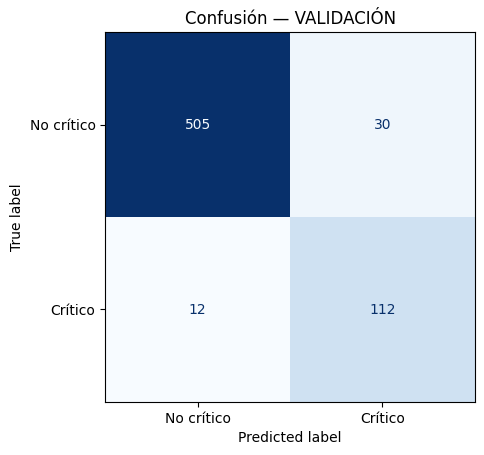


Matriz de confusión — TEST
[[75  6]
 [ 3 16]]


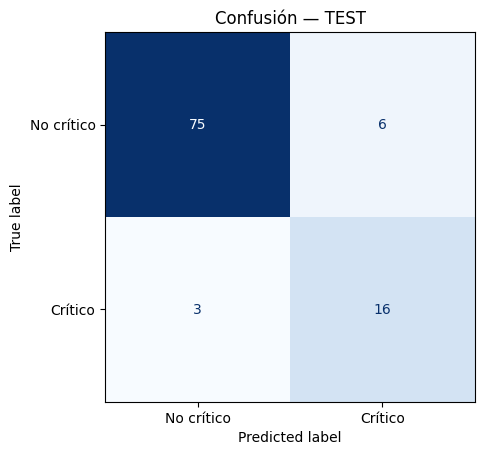

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


print("\nMatriz de confusión — VALIDACIÓN")
print(cm_val)

disp_val = ConfusionMatrixDisplay(
    confusion_matrix=cm_val,
    display_labels=["No crítico", "Crítico"]
)
disp_val.plot(cmap="Blues", colorbar=False)
plt.title("Confusión — VALIDACIÓN")
plt.show()


print("\nMatriz de confusión — TEST")
print(cm_test)

disp_test = ConfusionMatrixDisplay(
    confusion_matrix=cm_test,
    display_labels=["No crítico", "Crítico"]
)
disp_test.plot(cmap="Blues", colorbar=False)
plt.title("Confusión — TEST")
plt.show()


In [ ]:
import os

export_dir = "./critico_clf_export"
os.makedirs(export_dir, exist_ok=True)
trainer.save_model(export_dir)
tok.save_pretrained(export_dir)


('./critico_clf_export/tokenizer_config.json',
 './critico_clf_export/special_tokens_map.json',
 './critico_clf_export/vocab.json',
 './critico_clf_export/merges.txt',
 './critico_clf_export/added_tokens.json',
 './critico_clf_export/tokenizer.json')

In [ ]:
from google.colab import drive
import os

# 1) Monta tu Drive en Colab
drive.mount('/content/drive')

# 2) Define la carpeta de exportación dentro de tu Drive
export_dir = '/content/drive/MyDrive/critico_clf_export'
os.makedirs(export_dir, exist_ok=True)

# 3) Guarda el modelo y el tokenizer en Drive
trainer.save_model(export_dir)
tok.save_pretrained(export_dir)

print(f"✅ Modelo y tokenizer exportados en: {export_dir}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Modelo y tokenizer exportados en: /content/drive/MyDrive/critico_clf_export
